In [1]:
from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import folium
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster
from folium import plugins 
import scipy.stats
from datetime import datetime
from selenium import webdriver
import os

In [2]:
#Importing data
derecho_calls = pd.read_csv('../data/911_Phone Calls_Derecho_050320_050420.csv')
tornado_calls = pd.read_csv('../data/911_Phone_Calls_Tornado_030320.csv')
derecho_dispatch = pd.read_csv('../data/Computer Aided Dispatch Data_Derecho Incidents 050320-050420.csv', skiprows = 2)
tornado_dispatch = pd.read_csv('../data/Computer Aided Dispatch Data_Tornado Incidents 030320.csv', skiprows = 2)
damage_points = gpd.read_file('../data/damage_points.geojson')
path_polygons = gpd.read_file('../data/path_polygons.geojson')
tornado_paths = gpd.read_file('../data/tornado_paths.geojson')
calls_2020 = pd.read_csv('../data/2020_calls.csv')

In [3]:
#Dropping superfluous columns
derecho_calls = derecho_calls.drop('CallTypeId', 1)
tornado_calls = tornado_calls.drop('CallTypeId', 1)
calls_2020 = calls_2020[['time', 'tencode', 'disposition']]

C:\Users\apcsm\AppData\Local\Temp/ipykernel_12040/2564426903.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  derecho_calls = derecho_calls.drop('CallTypeId', 1)
C:\Users\apcsm\AppData\Local\Temp/ipykernel_12040/2564426903.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  tornado_calls = tornado_calls.drop('CallTypeId', 1)


In [4]:
#Renaming columns
derecho_calls.columns = ['time', 'lat', 'lng', 'cell_tower_add']
tornado_calls.columns = ['time', 'lat', 'lng', 'cell_tower_add']
derecho_dispatch.columns = ['time', 'location', 'lat', 'lng', 'desc']
tornado_dispatch.columns = ['time', 'location', 'lat', 'lng', 'desc']

In [5]:
#Creating a geometry column for the csv files
derecho_calls['geometry'] = derecho_calls.apply(lambda x: Point((float(x.lng), float(x.lat))), axis = 1)
tornado_calls['geometry'] = tornado_calls.apply(lambda x: Point((float(x.lng), float(x.lat))), axis = 1)
derecho_dispatch['geometry'] = derecho_dispatch.apply(lambda x: Point((float(x.lng), float(x.lat))), axis = 1)
tornado_dispatch['geometry'] = tornado_dispatch.apply(lambda x: Point((float(x.lng), float(x.lat))), axis = 1)

In [6]:
#Creating geodataframes from csv files
derecho_calls_geo = gpd.GeoDataFrame(derecho_calls, crs = damage_points.crs, geometry = derecho_calls['geometry'])
tornado_calls_geo = gpd.GeoDataFrame(tornado_calls, crs = damage_points.crs, geometry = tornado_calls['geometry'])
derecho_dispatch_geo = gpd.GeoDataFrame(derecho_dispatch, crs = damage_points.crs, geometry = derecho_dispatch['geometry'])
tornado_dispatch_geo = gpd.GeoDataFrame(tornado_dispatch, crs = damage_points.crs, geometry = tornado_dispatch['geometry'])

In [7]:
#Changing time to a military format
derecho_calls_geo.time = pd.to_datetime(derecho_calls_geo.time)
tornado_calls_geo.time = pd.to_datetime(tornado_calls_geo.time)
derecho_dispatch_geo.time = pd.to_datetime(derecho_dispatch_geo.time)
tornado_dispatch_geo.time = pd.to_datetime(tornado_dispatch_geo.time)
calls_2020.time = pd.to_datetime(calls_2020.time)

In [8]:
#Creating geodataframes with NAs dropped
derecho_calls_geo_dropna = derecho_calls_geo.dropna()
tornado_calls_geo_dropna = tornado_calls_geo.dropna()

In [9]:
#Pulling out lat and lng data from damage_points df (for use with heatmapping points)
damage_points['lat'] = damage_points.geometry.y
damage_points['lng'] = damage_points.geometry.x

In [10]:
#Creating a weekday column for calls 2020, and changing the numberic values there to strings
calls_2020['weekday'] = calls_2020.time.dt.dayofweek
weekdays = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday',6:'Sunday'}
calls_2020.weekday = calls_2020.weekday.replace(weekdays)

In [172]:
derecho_calls_geo.loc[(derecho_calls_geo.time >= pd.to_datetime('2020-05-03 23:30:00')) & (derecho_calls_geo.time < pd.to_datetime('2020-05-04 00:30:00'))].count()

time              40
lat               39
lng               39
cell_tower_add    40
geometry          40
dtype: int64

<AxesSubplot:>

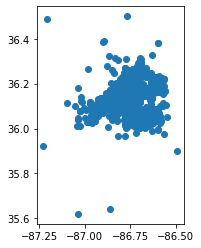

In [11]:
derecho_calls_geo.plot()

<AxesSubplot:>

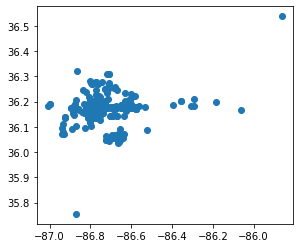

In [12]:
tornado_calls_geo.plot()

<AxesSubplot:>

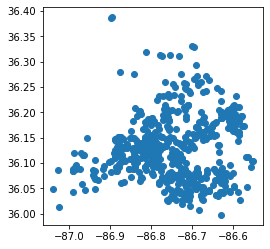

In [13]:
derecho_dispatch_geo.plot()

<AxesSubplot:>

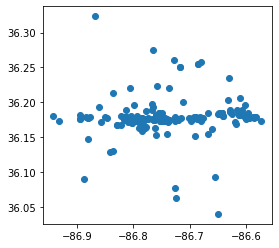

In [14]:
tornado_dispatch_geo.plot()

<AxesSubplot:>

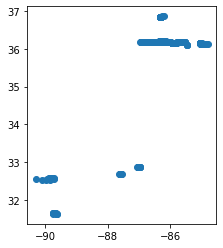

In [15]:
damage_points.plot()

<AxesSubplot:>

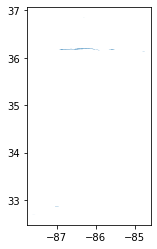

In [16]:
path_polygons.plot()

<AxesSubplot:>

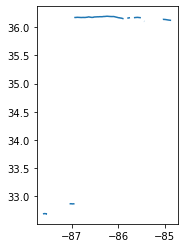

In [17]:
tornado_paths.plot()

In [113]:
damage_points.head()

objectid      stormdate     surveydate      event_id  damage  \
0   2047717  1583218620000  1583335680000  Mount Juliet       2   
1   2047909  1583221860000  1583437860000    Cookeville      27   
2   2075630  1583221980000  1586759820000    Cookeville       2   
3   2060941  1583217780000  1585242540000                     1   
4   2060984  1583217780000  1585256400000                     7   

                                  damage_txt  \
0       One- or Two-Family Residences (FR12)   
1                       Trees: Hardwood (TH)   
2       One- or Two-Family Residences (FR12)   
3     Small Barns or Farm Outbuildings (SBO)   
4  Masonry Apartment or Motel Building (MAM)   

                                             dod_txt efscale damage_dir  \
0                                All walls collapsed     EF3        N/A   
1                                     Trees uprooted     EF0        N/A   
2  Loss of roof covering material (<20%), gutters...     EF0        N/A   
3                      Total destruction of building     EF1        N/A   
4                       Loss of roof covering (<20%)     EF0        N/A   

  windspeed  ...  qc  dod  surveytype                                globalid  \
0       155  ...   Y    9        None  {FE82BBAC-ABF8-4562-81F6-A527829FBFFE}   
1        80  ...   Y    3        None  {2417B433-0C00-4D6C-A059-45E0CFDA2AF6}   
2        80  ...   Y    2        None  {10AC67A3-D75D-4E6E-82B8-DD307E183FC0}   
3        95  ...   Y    8        None  {A0744CB4-5993-4056-A13C-CF75182F5147}   
4        80  ...   Y    2        None  {DA83D428-084A-4ACA-A39E-DEE84AA28463}   

  edit_user edit_time comments path_guid                    geometry       lng  
0      None      None     none      None  POINT (-86.51628 36.18344) -86.51628  
1      None      None     none      None  POINT (-85.60552 36.17308) -85.60552  
2      None      None     None      None  POINT (-85.57574 36.17740) -85.57574  
3      None      None     None      None  POINT (-86.76228 36.17340) -86.76228  
4      None      None     None      None  POINT (-86.75692 36.17568) -86.75692  

[5 rows x 28 columns]

In [112]:
map = folium.Map(location = [36.134256, -86.822034], zoom_start = 10)

#folium.GeoJson(damage_points).add_to(map)

#folium.GeoJson(path_polygons).add_to(map)

folium.GeoJson(tornado_paths, style_function = lambda x: {'color':'red', 'fillcolor':'#ffc183'}).add_to(map)

#damageArr = damage_points[['lat','lng']].values
#map.add_child(plugins.HeatMap(damageArr, radius = 15))

map

In [111]:
map = folium.Map(location = [36.134256, -86.822034], zoom_start = 10) 

#Note I subset the dfs because the 'time' column being in a time format gives an error when we try to plot the points- I 
#just temporarily remove the 'time' column to get around this.


#folium.GeoJson(derecho_calls_geo_dropna[['lat', 'lng', 'cell_tower_add', 'geometry']]).add_to(map) 

#folium.GeoJson(tornado_calls_geo_dropna[['lat','lng','cell_tower_add','geometry']]).add_to(map)

#folium.GeoJson(derecho_dispatch_geo[['location', 'lat', 'lng', 'desc', 'geometry']]).add_to(map)

#folium.GeoJson(tornado_dispatch_geo[['location', 'lat', 'lng', 'desc', 'geometry']]).add_to(map)


map

In [20]:
#Tornado 911 calls, dispatches, and tornado path
map = folium.Map(location = [36.134256, -86.822034], zoom_start = 10)

for row_index, row_values in tornado_calls_geo_dropna.iterrows():
    loc = [row_values['lat'], row_values['lng']]
    pop = str(row_values['cell_tower_add'])
    
    marker = folium.CircleMarker(location = loc, radius = 1, popup = pop, weight = 3, color = 'red')
    
    marker.add_to(map)

for row_index, row_values in tornado_dispatch_geo.iterrows():
    loc = [row_values['lat'], row_values['lng']]
    pop = str(row_values['desc'])
    
    marker = folium.CircleMarker(location = loc, radius = 1, popup = pop, weight = 3, color = 'green')
    
    marker.add_to(map)

#folium.GeoJson(path_polygons, style_function = lambda x: {'color': '#000000'}).add_to(map)

map


In [21]:
#Derecho 911 calls and dispatches 
map = folium.Map(location = [36.134256, -86.822034], zoom_start = 10)

for row_index, row_values in derecho_calls_geo_dropna.iterrows():
    loc = [row_values['lat'], row_values['lng']]
    pop = str(row_values['cell_tower_add'])
    
    marker = folium.CircleMarker(location = loc, radius = 1, popup = pop, weight = 2, color = 'red')
    
    marker.add_to(map)


for row_index, row_values in derecho_dispatch_geo.iterrows():
    loc = [row_values['lat'], row_values['lng']]
    pop = str(row_values['desc'])
    
    marker = folium.CircleMarker(location = loc, radius = 1, popup = pop, weight = 2, color = 'black')
    
    marker.add_to(map)
    
map

## 1. Develop a timeline of each storm based on the call locations and volume. This can include the following:
#### - Beginning and end of the event, based on call times
#### - Times of stronger storm impacts, based on call volumes


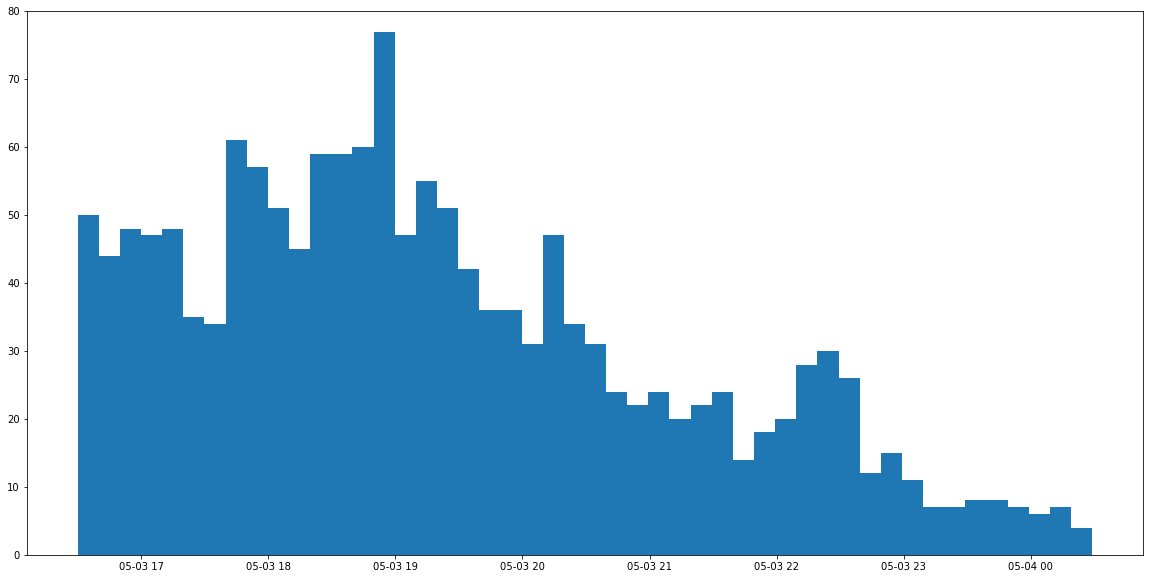

In [103]:
#Derecho call frequency using derecho_calls data
plt.figure(figsize = (20, 10))
plt.hist(derecho_calls_geo.time, bins = 48); #479 is the number of minutes from the first to last call of this dataset
axes = plt.gca()
axes.set_ylim([0,80])
plt.show()

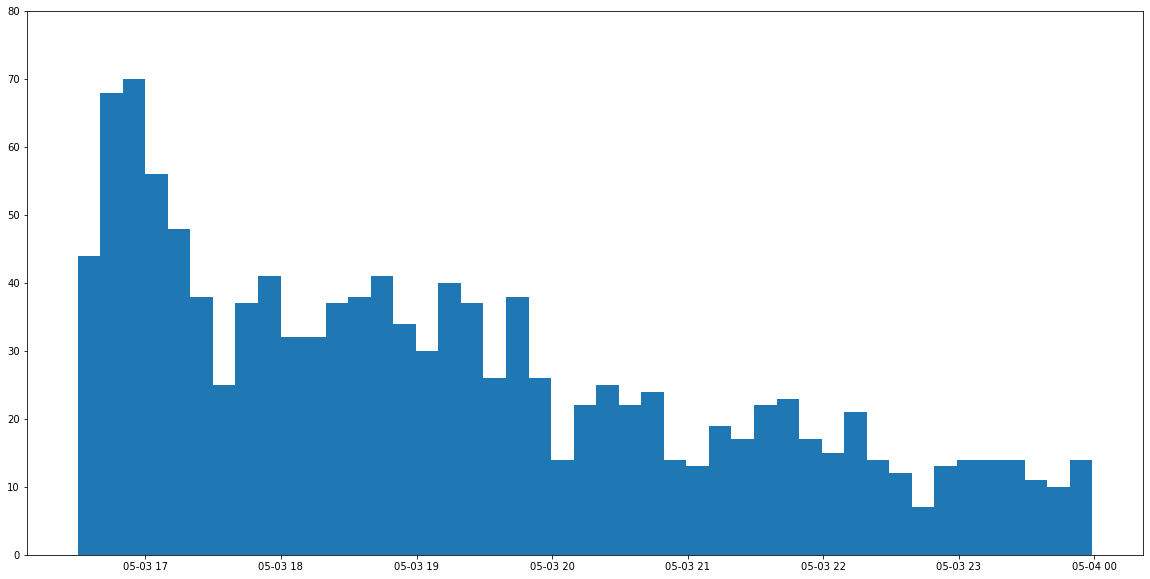

In [108]:
#Derecho calls frequency using calls_2020 data, ignoring last 30 mins of data
plt.figure(figsize = (20, 10))
plt.hist(calls_2020.time.loc[(calls_2020.time >= pd.to_datetime('2020-05-03 16:30:00')) & (calls_2020.time < pd.to_datetime('2020-05-04 00:00:00'))], bins = 45);
axes = plt.gca()
axes.set_ylim([0,80])
plt.show()

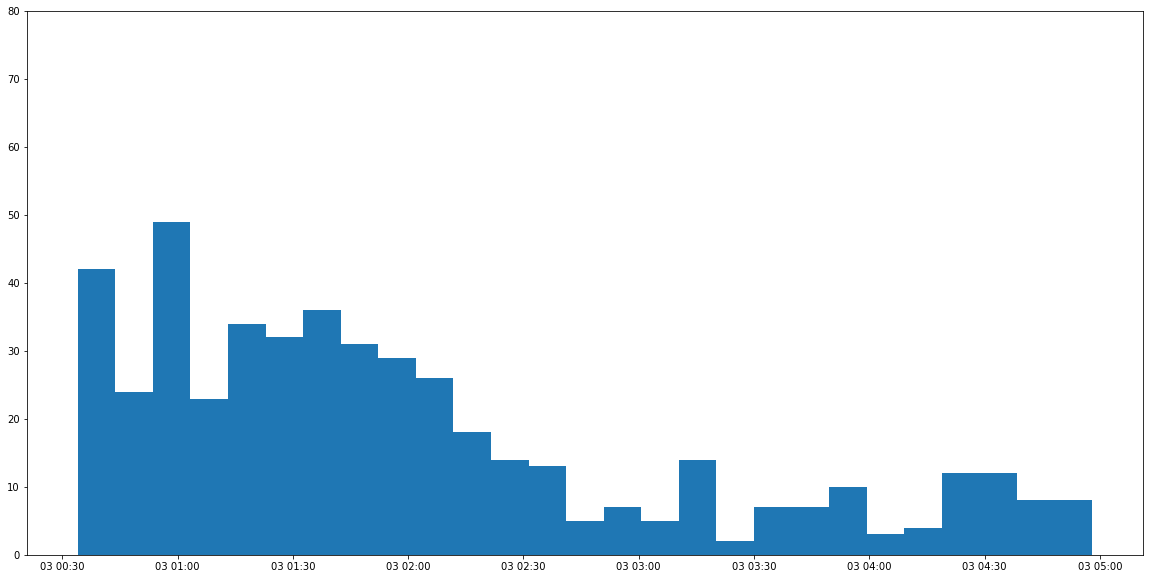

In [104]:
#Tornado calls frequency using tornado_calls data
plt.figure(figsize = (20, 10))
plt.hist(tornado_calls_geo.time, bins = 27); #254 is the number of minutes from the first to last call of this dataset.
axes = plt.gca()
axes.set_ylim([0,80])
plt.show()

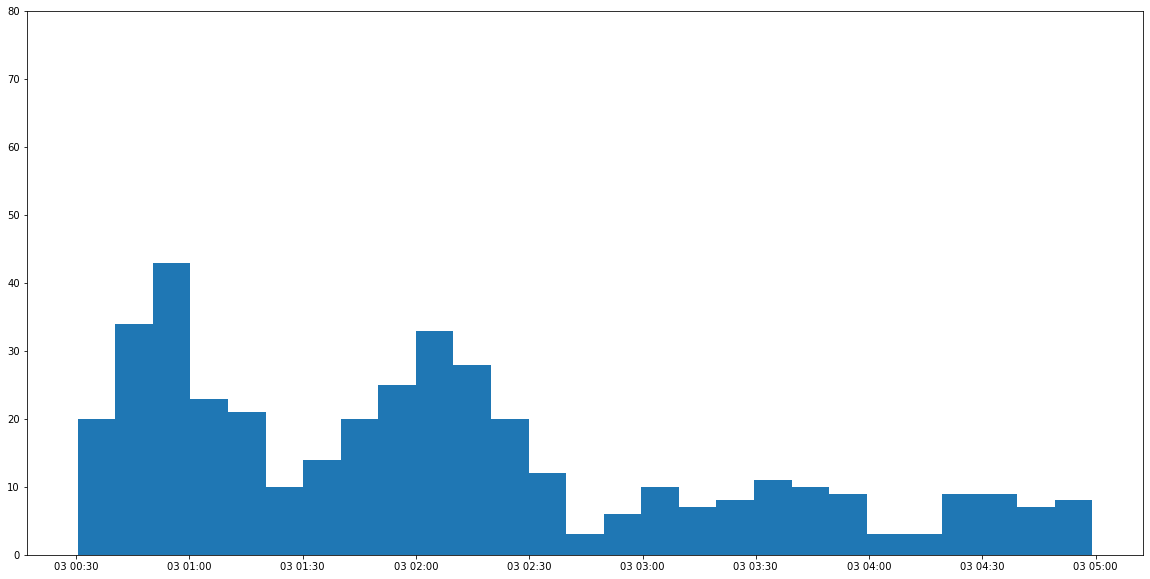

In [105]:
#Tornado calls frequency using calls_2020 data
plt.figure(figsize = (20, 10))
plt.hist(calls_2020.time.loc[(calls_2020.time >= pd.to_datetime('2020-03-03 00:30:00')) & (calls_2020.time < pd.to_datetime('2020-03-03 05:00:00'))], bins = 27);
axes = plt.gca()
axes.set_ylim([0,80])
plt.show()

In [58]:
calls_2020.head()

time                                   tencode  \
0 2020-01-01 00:00:02               COMMUNITY POLICING ACTIVITY   
1 2020-01-01 00:00:02  WANT OFFICER FOR INVESTIGATION / ASSISTA   
2 2020-01-01 00:00:06                            BUSINESS CHECK   
3 2020-01-01 00:00:09                            BUSINESS CHECK   
4 2020-01-01 00:00:10  WANT OFFICER FOR INVESTIGATION / ASSISTA   

                disposition    weekday  
0          ASSISTED CITIZEN  Wednesday  
1          ASSISTED CITIZEN  Wednesday  
2  LOCATION/BUILDING SECURE  Wednesday  
3  LOCATION/BUILDING SECURE  Wednesday  
4          ASSISTED CITIZEN  Wednesday

In [26]:
sunday_calls_2020 = calls_2020.loc[calls_2020.weekday == 'Sunday'].reset_index()
monday_calls_2020 = calls_2020.loc[calls_2020.weekday == 'Monday'].reset_index()
tuesday_calls_2020 = calls_2020.loc[calls_2020.weekday == 'Tuesday'].reset_index()

In [27]:
sunday_calls_2020['time'] = sunday_calls_2020['time'].astype(str)
monday_calls_2020['time'] = monday_calls_2020['time'].astype(str)
tuesday_calls_2020['time'] = tuesday_calls_2020['time'].astype(str)

In [28]:
sunday_calls_2020['time'] = sunday_calls_2020.time.str[11:]
monday_calls_2020['time'] = monday_calls_2020.time.str[11:]
tuesday_calls_2020['time'] = tuesday_calls_2020.time.str[11:]

In [29]:
sunday_calls_2020.time = pd.to_datetime(sunday_calls_2020.time)
monday_calls_2020.time = pd.to_datetime(monday_calls_2020.time)
tuesday_calls_2020.time = pd.to_datetime(tuesday_calls_2020.time)

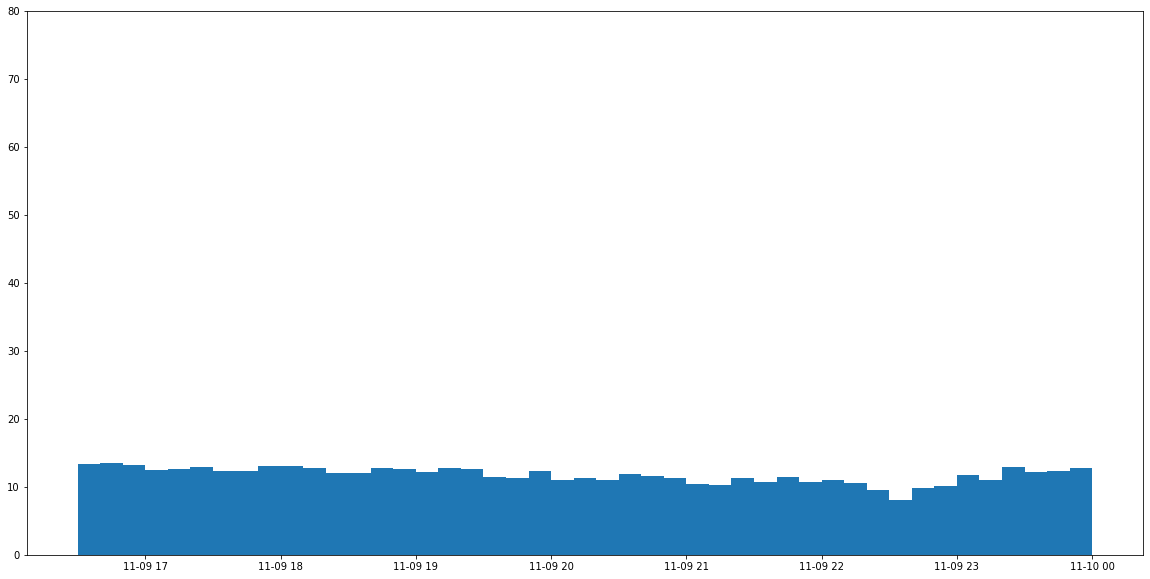

In [106]:
#Avg sunday call frequency, using calls_2020 data (for comparison to derecho calls, last 30 mins missing)
plt.figure(figsize = (20, 10))
n, bins, rects = plt.hist(sunday_calls_2020.time.loc[(sunday_calls_2020.time >= pd.to_datetime('2021-11-09 16:30:00'))], bins = 45); #450
axes = plt.gca()
axes.set_ylim([0,80]) #12
for r in rects:
    r.set_height(r.get_height()/52)

plt.show()

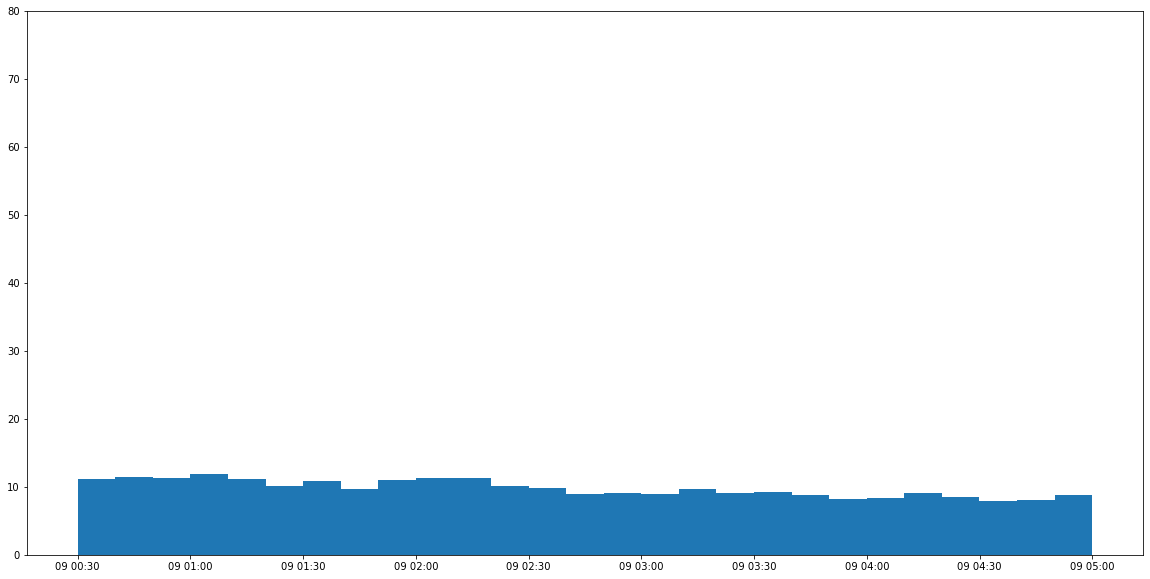

In [107]:
#Avg tuesday call frequency, using calls_2020 data (for comparison to tornado calls)
plt.figure(figsize = (20, 10))
n, bins, rects = plt.hist(tuesday_calls_2020.time.loc[(tuesday_calls_2020.time >= pd.to_datetime('2021-11-09 00:30:00')) & (tuesday_calls_2020.time < pd.to_datetime('2021-11-09 05:00:00'))], bins = 27); #270
axes = plt.gca()
axes.set_ylim([0,80]) #12
for r in rects:
    r.set_height(r.get_height()/52)

plt.show()

In [63]:
sunday_calls_2020.head(30)

index                time                                   tencode  \
0    7591 2021-11-09 00:02:12                               SHOTS FIRED   
1    7592 2021-11-09 00:02:13  WANT OFFICER FOR INVESTIGATION / ASSISTA   
2    7593 2021-11-09 00:02:13              INVESTIGATE 911 HANG-UP CALL   
3    7594 2021-11-09 00:03:11                         SUSPICIOUS PERSON   
4    7595 2021-11-09 00:03:47  WANT OFFICER FOR INVESTIGATION / ASSISTA   
5    7596 2021-11-09 00:04:24                         TRAFFIC VIOLATION   
6    7597 2021-11-09 00:05:30                         DISORDERLY PERSON   
7    7598 2021-11-09 00:06:02                         TRAFFIC VIOLATION   
8    7599 2021-11-09 00:06:15                            BUSINESS CHECK   
9    7600 2021-11-09 00:06:21  WANT OFFICER FOR INVESTIGATION / ASSISTA   
10   7601 2021-11-09 00:06:25                                     THEFT   
11   7602 2021-11-09 00:08:28                         DISORDERLY PERSON   
12   7603 2021-11-09 00:08:29                         SUSPICIOUS PERSON   
13   7604 2021-11-09 00:08:54              INVESTIGATE 911 HANG-UP CALL   
14   7605 2021-11-09 00:10:51  WANT OFFICER FOR INVESTIGATION / ASSISTA   
15   7606 2021-11-09 00:11:40                         TRAFFIC VIOLATION   
16   7607 2021-11-09 00:11:47  WANT OFFICER FOR INVESTIGATION / ASSISTA   
17   7608 2021-11-09 00:11:54  WANT OFFICER FOR INVESTIGATION / ASSISTA   
18   7609 2021-11-09 00:12:57                      BURGLARY - RESIDENCE   
19   7610 2021-11-09 00:13:11                         TRAFFIC VIOLATION   
20   7611 2021-11-09 00:13:15                         DISORDERLY PERSON   
21   7612 2021-11-09 00:14:26                            BUSINESS CHECK   
22   7613 2021-11-09 00:14:33                      BURGLARY - RESIDENCE   
23   7614 2021-11-09 00:15:38                        INTOXICATED PERSON   
24   7615 2021-11-09 00:16:05              INVESTIGATE 911 HANG-UP CALL   
25   7616 2021-11-09 00:16:56  WANT OFFICER FOR INVESTIGATION / ASSISTA   
26   7617 2021-11-09 00:21:20                         SUSPICIOUS PERSON   
27   7618 2021-11-09 00:22:22  WANT OFFICER FOR INVESTIGATION / ASSISTA   
28   7619 2021-11-09 00:24:16                                     THEFT   
29   7620 2021-11-09 00:24:59                         DISORDERLY PERSON   

                 disposition weekday  
0       DISREGARD / SIGNAL 9  Sunday  
1           ASSISTED CITIZEN  Sunday  
2       DISREGARD / SIGNAL 9  Sunday  
3                        NaN  Sunday  
4            GONE ON ARRIVAL  Sunday  
5                        NaN  Sunday  
6        ASSISTED OTHER UNIT  Sunday  
7        ASSISTED OTHER UNIT  Sunday  
8         COMMUNITY POLICING  Sunday  
9                NO RESPONSE  Sunday  
10     M.P.D. REPORT COMPLED  Sunday  
11           GONE ON ARRIVAL  Sunday  
12          ASSISTED CITIZEN  Sunday  
13                FALSE CALL  Sunday  
14       ASSISTED OTHER UNIT  Sunday  
15            SUBJECT WARNED  Sunday  
16           GONE ON ARRIVAL  Sunday  
17     M.P.D. REPORT COMPLED  Sunday  
18                       NaN  Sunday  
19                       NaN  Sunday  
20           GONE ON ARRIVAL  Sunday  
21  LOCATION/BUILDING SECURE  Sunday  
22  LOCATION/BUILDING SECURE  Sunday  
23          ASSISTED CITIZEN  Sunday  
24           GONE ON ARRIVAL  Sunday  
25       ASSISTED OTHER UNIT  Sunday  
26            SUBJECT WARNED  Sunday  
27          ASSISTED CITIZEN  Sunday  
28          ASSISTED CITIZEN  Sunday  
29                       NaN  Sunday

In [34]:
derecho_calls_geo.time = pd.to_datetime(derecho_calls_geo.time)

In [35]:
#Tornado 911 calls and tornado path
map = folium.Map(location = [36.134256, -86.822034], zoom_start = 10)

for row_index, row_values in tornado_calls_geo_dropna.iterrows():
    loc = [row_values['lat'], row_values['lng']]
    pop = str(row_values['cell_tower_add'])
    if row_values['time'] < pd.to_datetime('2020-03-03 01:00:00'):
        color = '#261a19'
    elif row_values['time'] < pd.to_datetime('2020-03-03 01:30:00'):
        color = '#3f2924'
    elif row_values['time'] < pd.to_datetime('2020-03-03 02:00:00'):
        color = '#663d30'
    elif row_values['time'] < pd.to_datetime('2020-03-03 02:30:00'):
        color = '#90573b'
    elif row_values['time'] < pd.to_datetime('2020-03-03 03:00:00'):
        color = '#c27945'
    elif row_values['time'] < pd.to_datetime('2020-03-03 03:30:00'):
        color = '#e7af64'
    elif row_values['time'] < pd.to_datetime('2020-03-03 04:00:00'):
        color = '#f4d692'
    elif row_values['time'] < pd.to_datetime('2020-03-03 04:30:00'):
        color = '#f3e8c4'
    
    marker = folium.CircleMarker(location = loc, radius = 1, popup = pop, weight = 3, color = color)
    
    marker.add_to(map)

folium.GeoJson(path_polygons, style_function = lambda x: {'color': 'lightblue'}).add_to(map)

map


In [132]:
#Heatmap of all 911 tornado calls
m = folium.Map(location = [36.15805611272429, -86.78008667375231], zoom_start = 10.5)

tornadocallArr = tornado_calls_geo_dropna[['lat', 'lng']].values
m.add_child(plugins.HeatMap(tornadocallArr, radius = 15))

m

In [114]:
map = folium.Map(location = [36.15805611272429, -86.78008667375231], zoom_start = 10.5)

tornadocallArr = (tornado_calls_geo_dropna.loc[tornado_calls_geo_dropna.time < pd.to_datetime('2020-03-03 01:00:00')])[['lat', 'lng']].values
map.add_child(plugins.HeatMap(tornadocallArr, radius = 15))

folium.GeoJson(tornado_paths, style_function = lambda x: {'color':'red', 'fillcolor':'#ffc183'}).add_to(map)

map

In [143]:
map = folium.Map(location = [36.15805611272429, -86.78008667375231], zoom_start = 10.5)

tornadocallArr = tornado_calls_geo_dropna.loc[(tornado_calls_geo_dropna.time >= pd.to_datetime('2020-03-03 01:00:00')) & (tornado_calls_geo_dropna.time < pd.to_datetime('2020-03-03 01:30:00'))][['lat', 'lng']].values
map.add_child(plugins.HeatMap(tornadocallArr, radius = 15))

folium.GeoJson(tornado_paths, style_function = lambda x: {'color':'red', 'fillcolor':'#ffc183', 'opacity':0.4}).add_to(map)

map

In [133]:
map = folium.Map(location = [36.15805611272429, -86.78008667375231], zoom_start = 10.5)

tornadocallArr = tornado_calls_geo_dropna.loc[(tornado_calls_geo_dropna.time >= pd.to_datetime('2020-03-03 01:30:00')) & (tornado_calls_geo_dropna.time < pd.to_datetime('2020-03-03 02:00:00'))][['lat', 'lng']].values
map.add_child(plugins.HeatMap(tornadocallArr, radius = 15))

folium.GeoJson(tornado_paths, style_function = lambda x: {'color':'red', 'fillcolor':'#ffc183', 'opacity':0.4}).add_to(map)

map

In [134]:
map = folium.Map(location = [36.15805611272429, -86.78008667375231], zoom_start = 10.5)

tornadocallArr = tornado_calls_geo_dropna.loc[(tornado_calls_geo_dropna.time >= pd.to_datetime('2020-03-03 02:00:00')) & (tornado_calls_geo_dropna.time < pd.to_datetime('2020-03-03 02:30:00'))][['lat', 'lng']].values
map.add_child(plugins.HeatMap(tornadocallArr, radius = 15))

folium.GeoJson(tornado_paths, style_function = lambda x: {'color':'red', 'fillcolor':'#ffc183', 'opacity':0.4}).add_to(map)

map

In [135]:
map = folium.Map(location = [36.15805611272429, -86.78008667375231], zoom_start = 10.5)

tornadocallArr = tornado_calls_geo_dropna.loc[(tornado_calls_geo_dropna.time >= pd.to_datetime('2020-03-03 02:30:00')) & (tornado_calls_geo_dropna.time < pd.to_datetime('2020-03-03 03:00:00'))][['lat', 'lng']].values
map.add_child(plugins.HeatMap(tornadocallArr, radius = 15))

folium.GeoJson(tornado_paths, style_function = lambda x: {'color':'red', 'fillcolor':'#ffc183', 'opacity':0.4}).add_to(map)

map

In [136]:
map = folium.Map(location = [36.15805611272429, -86.78008667375231], zoom_start = 10.5)

tornadocallArr = tornado_calls_geo_dropna.loc[(tornado_calls_geo_dropna.time >= pd.to_datetime('2020-03-03 03:00:00')) & (tornado_calls_geo_dropna.time < pd.to_datetime('2020-03-03 03:30:00'))][['lat', 'lng']].values
map.add_child(plugins.HeatMap(tornadocallArr, radius = 15))

folium.GeoJson(tornado_paths, style_function = lambda x: {'color':'red', 'fillcolor':'#ffc183', 'opacity':0.4}).add_to(map)

map

In [137]:
map = folium.Map(location = [36.15805611272429, -86.78008667375231], zoom_start = 10.5)

tornadocallArr = tornado_calls_geo_dropna.loc[(tornado_calls_geo_dropna.time >= pd.to_datetime('2020-03-03 03:30:00')) & (tornado_calls_geo_dropna.time < pd.to_datetime('2020-03-03 04:00:00'))][['lat', 'lng']].values
map.add_child(plugins.HeatMap(tornadocallArr, radius = 15))

folium.GeoJson(tornado_paths, style_function = lambda x: {'color':'red', 'fillcolor':'#ffc183', 'opacity':0.4}).add_to(map)

map

In [138]:
map = folium.Map(location = [36.15805611272429, -86.78008667375231], zoom_start = 10.5)

tornadocallArr = tornado_calls_geo_dropna.loc[(tornado_calls_geo_dropna.time >= pd.to_datetime('2020-03-03 04:00:00')) & (tornado_calls_geo_dropna.time < pd.to_datetime('2020-03-03 04:30:00'))][['lat', 'lng']].values
map.add_child(plugins.HeatMap(tornadocallArr, radius = 15))

folium.GeoJson(tornado_paths, style_function = lambda x: {'color':'red', 'fillcolor':'#ffc183', 'opacity':0.4}).add_to(map)

map

In [139]:
map = folium.Map(location = [36.15805611272429, -86.78008667375231], zoom_start = 10.5)

tornadocallArr = tornado_calls_geo_dropna.loc[(tornado_calls_geo_dropna.time >= pd.to_datetime('2020-03-03 04:30:00')) & (tornado_calls_geo_dropna.time < pd.to_datetime('2020-03-03 05:00:00'))][['lat', 'lng']].values
map.add_child(plugins.HeatMap(tornadocallArr, radius = 15))

folium.GeoJson(tornado_paths, style_function = lambda x: {'color':'red', 'fillcolor':'#ffc183', 'opacity':0.4}).add_to(map)

map

In [46]:
#Heatmap of all 911 derecho calls
map = folium.Map(location = [36.15805611272429, -86.78008667375231], zoom_start = 10.5)

derechocallArr = derecho_calls_geo_dropna[['lat', 'lng']].values
map.add_child(plugins.HeatMap(derechocallArr, radius = 15))

map

In [47]:
map = folium.Map(location = [36.15805611272429, -86.78008667375231], zoom_start = 10.5)

derechocallArr = derecho_calls_geo_dropna[derecho_calls_geo_dropna.time < pd.to_datetime('2020-05-03 17:30:00')][['lat', 'lng']].values
map.add_child(plugins.HeatMap(derechocallArr, radius = 15))

map

In [48]:
map = folium.Map(location = [36.15805611272429, -86.78008667375231], zoom_start = 10.5)

derechocallArr = derecho_calls_geo_dropna[(derecho_calls_geo_dropna.time >= pd.to_datetime('2020-05-03 17:30:00')) & (derecho_calls_geo_dropna.time < pd.to_datetime('2020-05-03 18:30:00'))][['lat', 'lng']].values
map.add_child(plugins.HeatMap(derechocallArr, radius = 15))

map

In [49]:
map = folium.Map(location = [36.15805611272429, -86.78008667375231], zoom_start = 10.5)

derechocallArr = derecho_calls_geo_dropna[(derecho_calls_geo_dropna.time >= pd.to_datetime('2020-05-03 18:30:00')) & (derecho_calls_geo_dropna.time < pd.to_datetime('2020-05-03 19:30:00'))][['lat', 'lng']].values
map.add_child(plugins.HeatMap(derechocallArr, radius = 15))

map

In [50]:
map = folium.Map(location = [36.15805611272429, -86.78008667375231], zoom_start = 10.5)

derechocallArr = derecho_calls_geo_dropna[(derecho_calls_geo_dropna.time >= pd.to_datetime('2020-05-03 19:30:00')) & (derecho_calls_geo_dropna.time < pd.to_datetime('2020-05-03 20:30:00'))][['lat', 'lng']].values
map.add_child(plugins.HeatMap(derechocallArr, radius = 15))

map

In [51]:
map = folium.Map(location = [36.15805611272429, -86.78008667375231], zoom_start = 10.5)

derechocallArr = derecho_calls_geo_dropna[(derecho_calls_geo_dropna.time >= pd.to_datetime('2020-05-03 20:30:00')) & (derecho_calls_geo_dropna.time < pd.to_datetime('2020-05-03 21:30:00'))][['lat', 'lng']].values
map.add_child(plugins.HeatMap(derechocallArr, radius = 15))

map

In [52]:
map = folium.Map(location = [36.15805611272429, -86.78008667375231], zoom_start = 10.5)

derechocallArr = derecho_calls_geo_dropna[(derecho_calls_geo_dropna.time >= pd.to_datetime('2020-05-03 21:30:00')) & (derecho_calls_geo_dropna.time < pd.to_datetime('2020-05-03 22:30:00'))][['lat', 'lng']].values
map.add_child(plugins.HeatMap(derechocallArr, radius = 15))

map

In [53]:
map = folium.Map(location = [36.15805611272429, -86.78008667375231], zoom_start = 10.5)

derechocallArr = derecho_calls_geo_dropna[(derecho_calls_geo_dropna.time >= pd.to_datetime('2020-05-03 22:30:00')) & (derecho_calls_geo_dropna.time < pd.to_datetime('2020-05-03 23:30:00'))][['lat', 'lng']].values
map.add_child(plugins.HeatMap(derechocallArr, radius = 15))

map

In [54]:
map = folium.Map(location = [36.15805611272429, -86.78008667375231], zoom_start = 10.5)

derechocallArr = derecho_calls_geo_dropna[(derecho_calls_geo_dropna.time >= pd.to_datetime('2020-05-03 23:30:00')) & (derecho_calls_geo_dropna.time < pd.to_datetime('2020-06-03 00:30:00'))][['lat', 'lng']].values
map.add_child(plugins.HeatMap(derechocallArr, radius = 15))

map